In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install teeplot
from teeplot import teeplot as tp
from matplotlib.patches import Patch
from scipy.stats import kruskal
from IPython.display import display






# OSF identifier
data_id = "z54jc"

# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv(f"https://osf.io/{data_id}/download")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_10338/1613482059.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["S"] = data["Surface Size (S)"]
/tmp/ipykernel_10338/1613482059.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tsize"] = data["T Size"]
/tmp/ipykernel_10338/1613482059.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,Algorithm,H-statistic,p-value
0,steady,2.119,0.346634
1,stretched,2.650,0.265756
2,tilted,12.920,0.001565


teeplots/hue=s+viz=plot-mean-real-execution-time-ps+x=algorithm+y=real-time-per-site-ns+ext=.pdf
teeplots/hue=s+viz=plot-mean-real-execution-time-ps+x=algorithm+y=real-time-per-site-ns+ext=.png


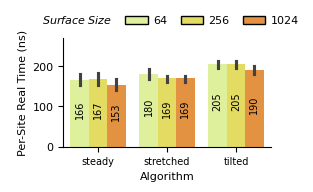

In [2]:


def plot_mean_real_execution_time_ps(data, **kwargs):
    # rename the algorithm labels
    data["algorithm"] = data["Algorithm"].replace({
        "steady_assign_storage_site_batched": "steady",
        "stretched_assign_storage_site_batched": "stretched",
        "tilted_assign_storage_site_batched": "tilted",
    })

    # filter to only include rows where T Upper Bound == 2^32
    data = data[data["T Upper Bound"] == 4294967296]

    # assign S and Tsize directly
    data["S"] = data["Surface Size (S)"]
    data["Tsize"] = data["T Size"]

    # convert to nanoseconds per site
    data["Real Time Per Site (ns)"] = (
        data["Real Execution Time"] * 1e9
        / data["Tsize"]
    )

    # perform Kruskal-Wallis test per algorithm, comparing across surface sizes
    kruskal_results = []
    for algo, grp in data.groupby("algorithm"):
        # gather Real Time values for each surface size within this algorithm
        samples = [g["Real Time Per Site (ns)"].values for _, g in grp.groupby("S")]
        if len(samples) > 1:
            stat, p_val = kruskal(*samples)
        else:
            stat, p_val = float('nan'), float('nan')

        kruskal_results.append({
            "Algorithm": algo,
            "H-statistic": round(stat, 3) if not pd.isna(stat) else stat,
            "p-value": p_val
        })

    # build & display the results table
    kruskal_df = pd.DataFrame(kruskal_results)
    display(kruskal_df)


    # group by algorithm, S and compute mean per-site time
    # grouped = data.groupby(["algorithm", "S"], as_index=False)["Real Time Per Site (ns)"].mean()

    # bar plot
    plt.figure(figsize=(3, 2))  # these are IRL dimensions
    ax = sns.barplot(data=data, **kwargs, alpha=0.85, palette='Wistia')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # add labels to the bars
    for container in ax.containers:
        labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, fmt='%d', fontsize=7, padding=3, rotation=90, label_type = 'center')

    # better readability
    plt.xlabel("Algorithm", fontsize=8)
    plt.ylabel("Per-Site Real Time (ns)", fontsize=8)

    # keep x-axis labels horizontal
    plt.xticks(fontsize=7, rotation=0)
    plt.yticks(fontsize=8)

    # ylim adjustment
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)

    # legend
    handles, labels = ax.get_legend_handles_labels()

    # Rebuild square patch handles from the bar containers
    colors = [bar.patches[0].get_facecolor() for bar in ax.containers[:3]]
    color_handles = [Patch(facecolor=c, edgecolor='black') for c in colors]

    # Create a dummy handle for inline title
    title_handle = Patch(facecolor='none', edgecolor='none')
    legend_handles = [title_handle] + color_handles
    legend_labels = [r"$\it{Surface\;Size}$"] + labels  # italic + spacing

    # legend
    plt.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=8,
        loc="lower center",
        bbox_to_anchor=(0.45, 1.02),
        ncol=4,
        columnspacing=1.2,
        handletextpad=0.5,
        frameon=False
    )

    # layout adjustment
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout(pad=1)


# teeplot
tp.tee(plot_mean_real_execution_time_ps, data=df, x="algorithm", y="Real Time Per Site (ns)", hue="S")
